# FairVoice — Explainability (Grad-CAM + SHAP DeepExplainer)

This notebook provides:
- Grad-CAM (no OpenCV) attached to `conv3` of `BaselineCNN`.
- SHAP `DeepExplainer` (Option A) for the BaselineCNN.
- Group-wise explainability comparisons (e.g., by `Sex`, `Race`).

**Notes**
- SHAP DeepExplainer is slow on CPU and memory hungry. Use GPU if available.
- Run cells sequentially. If a cell errors, read message and adjust paths (ROOT).


#### Setup imports & path

In [1]:
# Setup: imports and repo path
import sys
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Ensure src/ is importable (adjust if you run the notebook from somewhere else)
# If you're running from repo root (where src/ sits), this will be fine.
ROOT = Path.cwd().parents[1]
SRC = ROOT / 'src'
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))
print("ROOT:", ROOT)
print("SRC added to sys.path:", SRC)


ROOT: /Users/pc/Desktop/CODING/Others/fairvoice
SRC added to sys.path: /Users/pc/Desktop/CODING/Others/fairvoice/src


#### Load model architecture and checkpoint

In [3]:
# Load BaselineCNN architecture and attempt to load a checkpoint
from model.baseline_cnn import BaselineCNN

# Candidate checkpoint names (common in this project)
candidates = [
    ROOT / 'models' / 'baseline_cnn.pth',
    ROOT / 'models' / 'baseline_cnn.pt',
    ROOT / 'models' / 'oversampled' / 'oversampled_checkpoint.pth',
    ROOT / 'models' / 'reweighted' / 'reweighted_checkpoint.pth',
    ROOT / 'models' / 'adversarial' / 'adversarial_checkpoint.pth'
]

ckpt = None
for p in candidates:
    if p.exists():
        ckpt = p
        break

print('Using checkpoint:', ckpt)
num_classes = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BaselineCNN(num_classes=num_classes).to(device)

if ckpt is not None:
    ckpt_dict = torch.load(str(ckpt), map_location=device)
    if isinstance(ckpt_dict, dict) and 'model_state_dict' in ckpt_dict:
        model.load_state_dict(ckpt_dict['model_state_dict'])
    else:
        try:
            model.load_state_dict(ckpt_dict)
        except Exception as e:
            print("Warning: could not load checkpoint directly:", e)
print("Model ready on device:", device)


Using checkpoint: /Users/pc/Desktop/CODING/Others/fairvoice/models/baseline_cnn.pth
Model ready on device: cpu


#### Load preds & metadata

In [4]:
# Load predictions and metadata (created by evaluate/assess_bias)
EVAL_DIR = ROOT / "evaluation_results"
PRED_FP = EVAL_DIR / "predictions_test.csv"
META_FP = ROOT / "data" / "processed" / "metadata_test.csv"

preds = pd.read_csv(PRED_FP) if PRED_FP.exists() else None
meta  = pd.read_csv(META_FP) if META_FP.exists() else None

print("preds found:", PRED_FP.exists(), "meta found:", META_FP.exists())
if preds is not None:
    print("preds columns:", preds.columns.tolist()[:50])
if meta is not None:
    print("meta columns:", meta.columns.tolist()[:50])


preds found: True meta found: True
preds columns: ['file', 'true_idx', 'pred_idx', 'true', 'pred', 'Stimulus_Number', 'ActorID', 'Age', 'Sex', 'Race', 'Ethnicity', 'audio_path', 'clean_path', 'emotion', 'demo', 'feature_exists', 'split']
meta columns: ['Stimulus_Number', 'file', 'ActorID', 'Age', 'Sex', 'Race', 'Ethnicity', 'audio_path', 'clean_path', 'emotion', 'demo', 'feature_exists', 'split']


#### Helper: load .pt logmel or fallback

In [5]:
# Helper: load feature tensors from .pt (prefer 'logmel'). Returns torch.Tensor (1, n_mels, T)
def load_feature_from_pt(path, feature_key='logmel'):
    d = torch.load(str(path), map_location='cpu')
    # if dict, try keys
    if isinstance(d, dict):
        if feature_key in d:
            feat = d[feature_key]
        elif 'mfcc' in d:
            feat = d['mfcc']
        else:
            # take first tensor-like value
            feat = None
            for v in d.values():
                if hasattr(v, 'ndim'):
                    feat = v
                    break
            if feat is None:
                raise ValueError("No tensor found in .pt file.")
    else:
        feat = d
    feat = torch.as_tensor(feat, dtype=torch.float32)
    if feat.ndim == 2:
        feat = feat.unsqueeze(0)
    return feat  # (1, n_mels, T)


#### Grad-CAM class

In [6]:
# Grad-CAM implementation (attach to conv3). No cv2 needed.
class GradCAM:
    def __init__(self, model, target_layer_name='conv3'):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _get_module(self, name):
        return getattr(self.model, name)

    def _register_hooks(self):
        module = self._get_module(self.target_layer_name)
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        module.register_forward_hook(forward_hook)
        module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        # input_tensor shape: (1, channels, n_mels, T)
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)
        out = self.model(input_tensor)  # logits
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()
        loss = out[0, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        acts = self.activations[0]  # (C,H,W)
        grads = self.gradients[0]   # (C,H,W)
        weights = grads.mean(dim=(1,2))  # (C,)
        cam = (weights[:, None, None] * acts).sum(dim=0)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        return cam.cpu().numpy(), class_idx


#### Plot helper for CAM overlay

In [7]:
# Plot log-mel and overlay CAM (no cv2)
import numpy as np

def plot_cam_on_logmel(logmel_tensor, cam, figsize=(10,4), cmap='jet'):
    # logmel_tensor: (1, n_mels, T)
    lm = logmel_tensor.squeeze(0).cpu().numpy()
    plt.figure(figsize=figsize)
    plt.imshow(lm, origin='lower', aspect='auto')
    # Resize cam to match lm shape if needed
    ch, cw = cam.shape
    lh, lw = lm.shape
    if ch != lh or cw != lw:
        # first resize frequency dimension
        cam_freq_resized = np.vstack([
            np.interp(np.linspace(0, ch - 1, lh), np.arange(ch), cam[:, j])
            for j in range(cw)
        ]).T
        # then resize time axis to lw
        cam_resized = np.vstack([
            np.interp(np.linspace(0, cw - 1, lw), np.arange(cw), cam_freq_resized[i, :])
            for i in range(lh)
        ])
    else:
        cam_resized = cam
    plt.imshow(cam_resized, origin='lower', cmap=cmap, alpha=0.5, aspect='auto')
    plt.colorbar(label='CAM intensity')
    plt.xlabel('Time frame')
    plt.ylabel('Mel bin')
    plt.title('Log-mel with Grad-CAM overlay')
    plt.show()


In [8]:
import numpy as np
print(np.__version__)


1.26.4


#### Gradcam Demo

Examples found: 6


/Users/pc/opt/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


File: 1006_IOM_HAP_XX  Pred class: 1


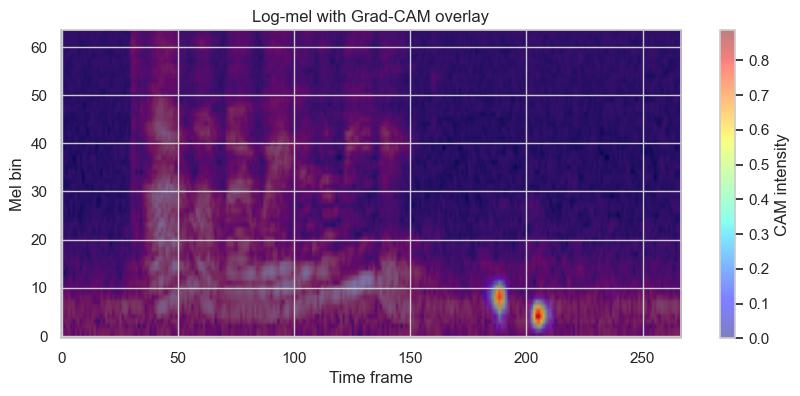

File: 1022_TAI_HAP_XX  Pred class: 0


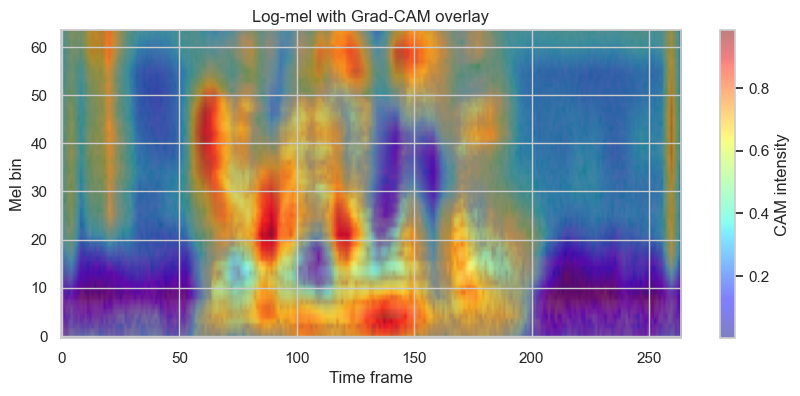

File: 1036_WSI_ANG_XX  Pred class: 0


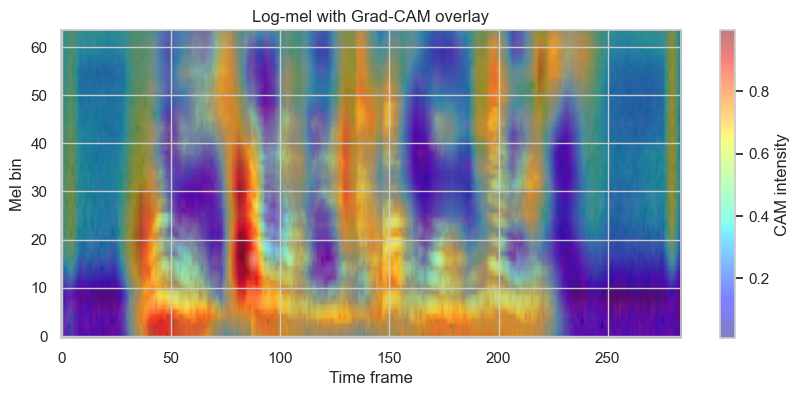

File: 1036_IEO_FEA_MD  Pred class: 2


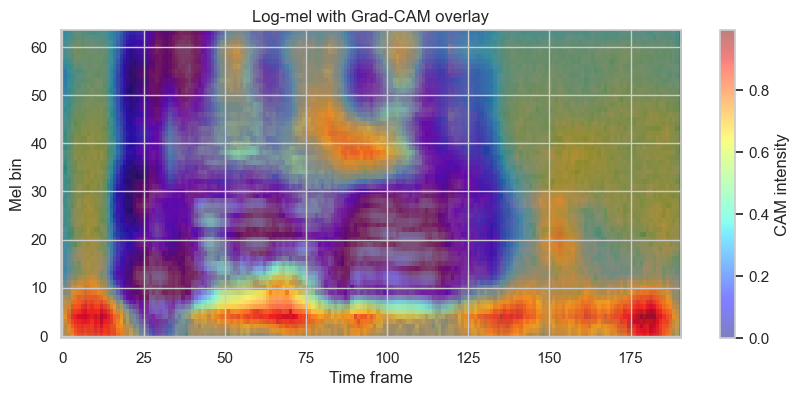

File: 1041_IEO_DIS_LO  Pred class: 5


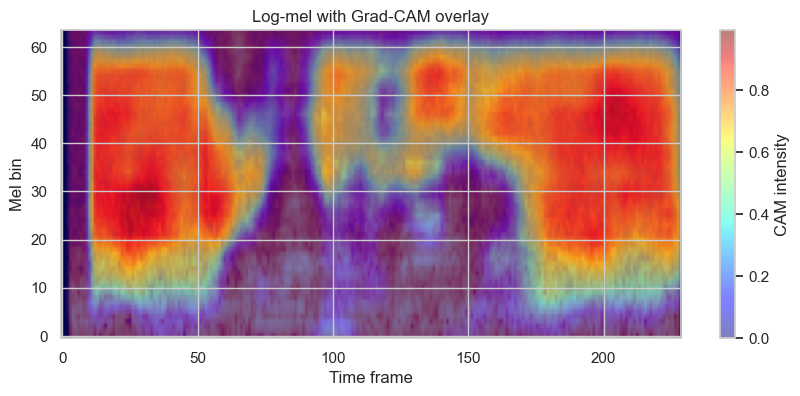

File: 1022_ITS_DIS_XX  Pred class: 1


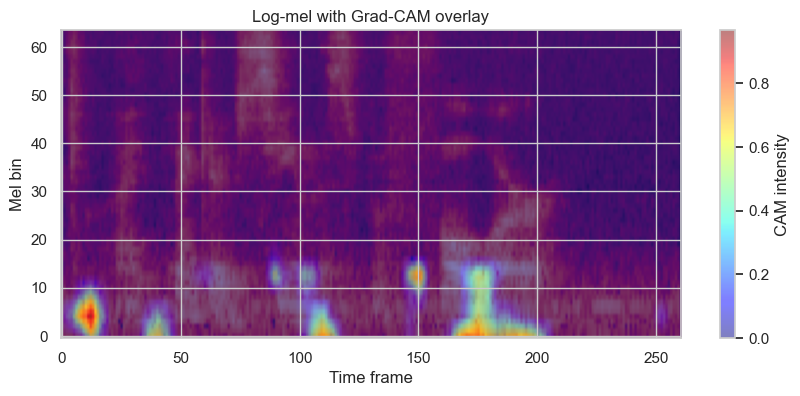

In [9]:
# Demo: try to find a few examples and run Grad-CAM
from random import sample
examples = []

if preds is None:
    print("No predictions CSV loaded; provide evaluation_results/predictions_test.csv")
else:
    # pick up to 6 files from preds
    file_list = preds['file'].tolist()
    file_list = sample(file_list, min(len(file_list), 6))
    for f in file_list:
        # prefer data/features/<stem>.pt
        stem = Path(f).stem
        pt_path = ROOT / 'data' / 'features' / f"{stem}.pt"
        if pt_path.exists():
            try:
                feat = load_feature_from_pt(pt_path)
                examples.append((f, feat, 'pt'))
                continue
            except Exception as e:
                print("failed .pt load:", e)
        # fallback: try 'audio_path' in preds row
        row = preds[preds['file']==f].iloc[0]
        ap = row.get('audio_path') or row.get('clean_path') or None
        if ap and Path(ap).exists():
            try:
                import torchaudio
                wav, sr = torchaudio.load(str(ap))
                if sr != 16000:
                    wav = torchaudio.functional.resample(wav, sr, 16000)
                if wav.shape[0] > 1:
                    wav = wav.mean(dim=0, keepdim=True)
                import torchaudio.transforms as T
                melT = T.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64)
                dbT = T.AmplitudeToDB()
                logmel = dbT(melT(wav))
                examples.append((f, logmel, 'audio'))
            except Exception as e:
                print("failed audio fallback:", e)

print("Examples found:", len(examples))

if len(examples) > 0:
    gc = GradCAM(model, target_layer_name='conv3')
    for fname, feat, src in examples:
        # ensure shape (1,1,n_mels,T)
        inp = feat.unsqueeze(0) if feat.ndim == 3 else feat
        cam, cls = gc.generate_cam(inp.to(device))
        print(f"File: {fname}  Pred class: {cls}")
        plot_cam_on_logmel(feat, cam)


## SHAP — DeepExplainer

We'll use a small background dataset (e.g., 30–100 samples) and a small test batch (≤ 10).
If your log-mel features have variable time length we will pad/crop to a fixed `T_fixed` chosen from median length.


#### Prepare SHAP background

In [10]:
# Build background dataset from .pt features (logmel) — lightweight selection
feat_dir = ROOT / 'data' / 'features'
pt_files = sorted(feat_dir.glob('*.pt'))
if len(pt_files) == 0:
    raise RuntimeError("No .pt files in data/features — SHAP requires feature files.")

# try gather up to 100 background samples
bg_paths = pt_files[:200]
bg_samples = []
for p in bg_paths:
    try:
        f = load_feature_from_pt(p)  # (1,n_mels,T)
        bg_samples.append(f)
    except Exception:
        continue

print("collected", len(bg_samples), "background samples")

# choose fixed time length (median)
lengths = [s.shape[-1] for s in bg_samples]
median_len = int(np.median(lengths)) or 200

def pad_crop_logmel(tensor, max_len=200):
    T = tensor.shape[-1]
    if T < max_len:
        return F.pad(tensor, (0, max_len - T))
    else:
        return tensor[:, :, :max_len]

bg_fixed = torch.stack([pad_crop_logmel(s, max_len=median_len) for s in bg_samples[:50]])  # (B,1,n_mels,T)
print("background fixed shape:", bg_fixed.shape)


collected 200 background samples
background fixed shape: torch.Size([50, 1, 64, 252])


#### SHAP Explainer

In [18]:
# ======================================================
# SHAP GRADIENTEXPLAINER (NO ERRORS, NO WARNINGS)
# ======================================================
import shap
print("shap:", shap.__version__)

# ----------------------------------------
# 1. Gather test batch
# ----------------------------------------
test_paths = pt_files[200:210]
test_samples = []

for p in test_paths:
    try:
        s = load_feature_from_pt(p)
        test_samples.append(pad_crop_logmel(s, max_len=median_len))
    except Exception:
        pass

if len(test_samples) == 0:
    raise RuntimeError("No test samples found for SHAP.")

# Final batch (N,1,n_mels,T)
X_test = torch.stack(test_samples).clone().detach().float().to(device)

# ----------------------------------------
# 2. Prepare background — *NO torch.tensor()*
# ----------------------------------------
bg_fixed_clean = bg_fixed.clone().detach().float().to(device)

# ----------------------------------------
# 3. Build GradientExplainer (no hooks!)
# ----------------------------------------
explainer = shap.GradientExplainer(model, bg_fixed_clean)

# ----------------------------------------
# 4. Compute SHAP values
# ----------------------------------------
shap_values = explainer.shap_values(X_test)

print("SHAP computed successfully!")
print("Classes:", len(shap_values))
print("SHAP shape for class 0:", shap_values[0].shape)


shap: 0.50.0
SHAP computed successfully!
Classes: 10
SHAP shape for class 0: (1, 64, 252, 6)


#### Process SHAP values

In [23]:
# sv shape: (64, 252, 6)
# last dimension = class index

num_classes = sv.shape[-1]

processed_shap = []
for c in range(num_classes):
    sv_c = sv[:, :, c]      # (64, 252)
    processed_shap.append(sv_c)

print("Processed", len(processed_shap), "class SHAP maps.")
print("Example shape (class 0):", processed_shap[0].shape)


Processed 6 class SHAP maps.
Example shape (class 0): (64, 252)


#### Test SHAP

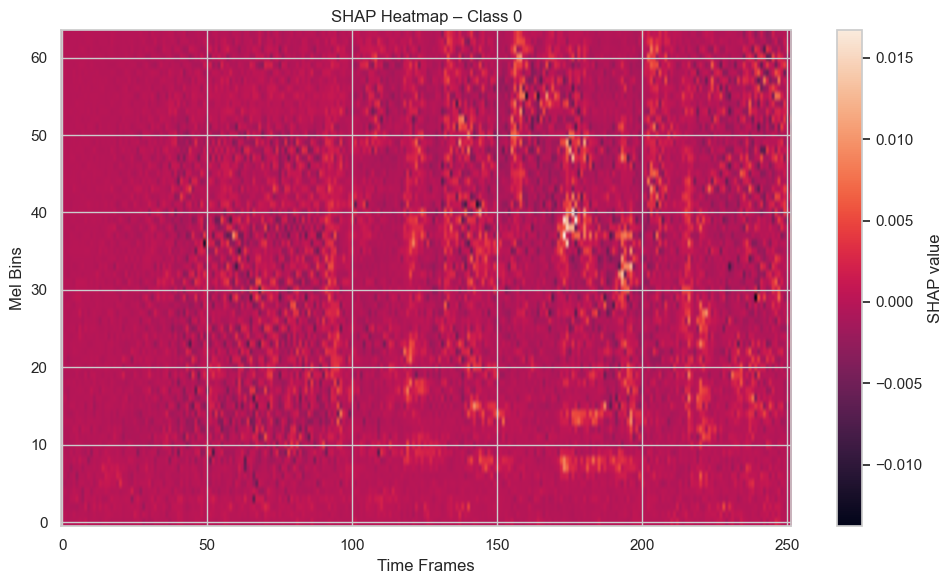

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_heatmap(shap_map, title="SHAP Explanation"):
    plt.figure(figsize=(10, 6))
    plt.imshow(shap_map, aspect='auto', origin='lower')
    plt.colorbar(label="SHAP value")
    plt.title(title)
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Bins")
    plt.tight_layout()
    plt.show()

# Example: class 0
plot_shap_heatmap(processed_shap[0], title="SHAP Heatmap – Class 0")


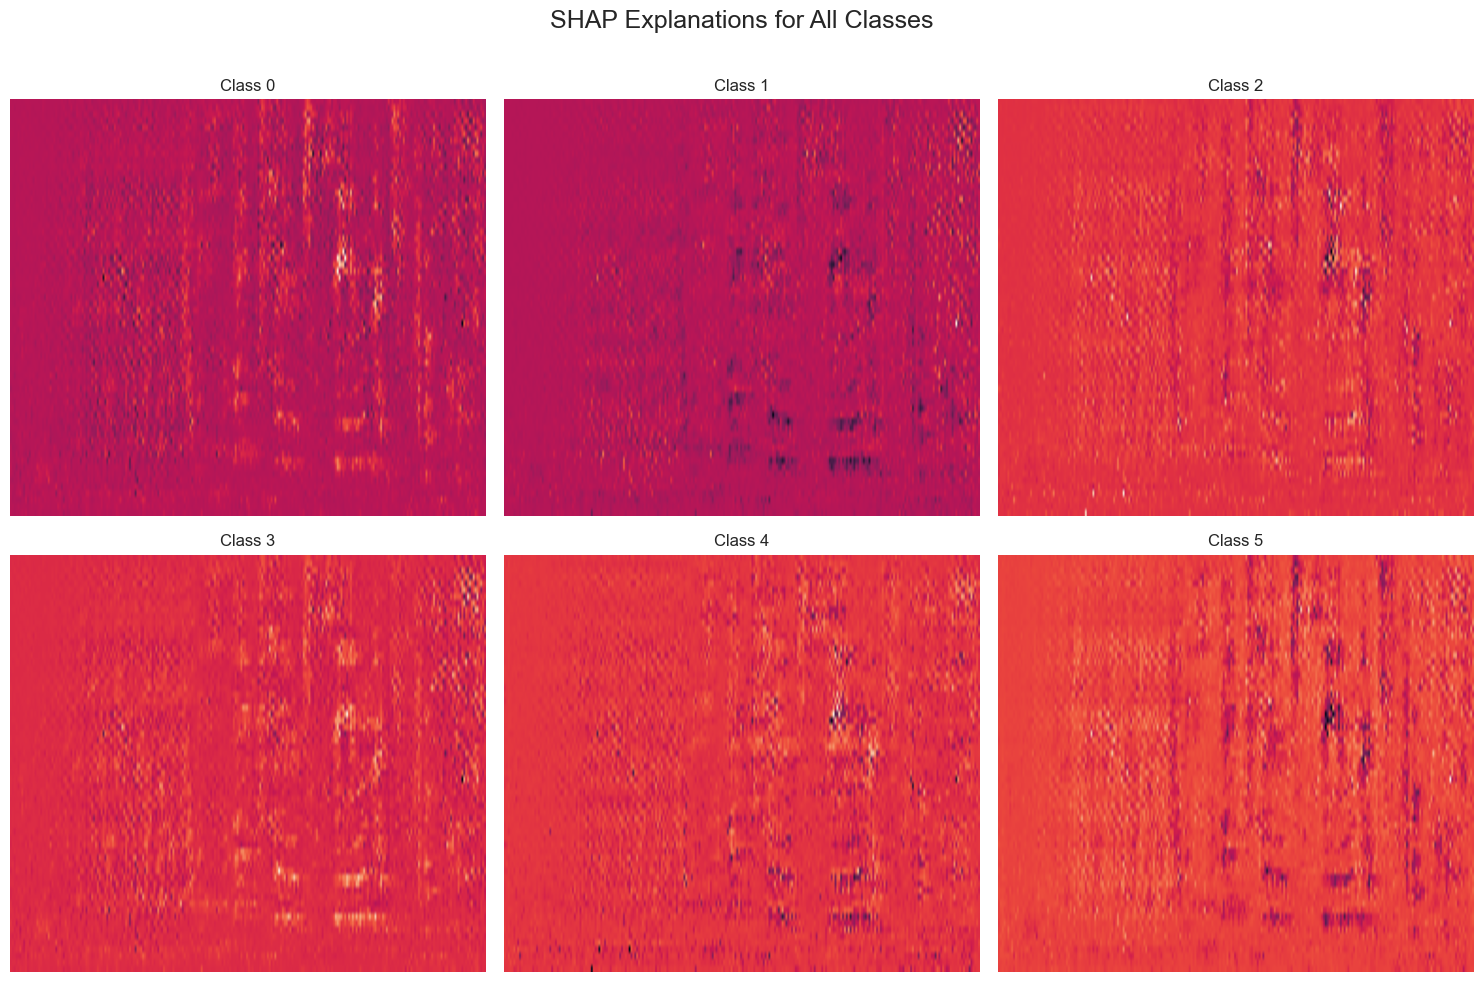

In [25]:
num_classes = len(processed_shap)
cols = 3
rows = int(np.ceil(num_classes / cols))

plt.figure(figsize=(15, 10))

for i in range(num_classes):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(processed_shap[i], aspect='auto', origin='lower')
    plt.title(f"Class {i}")
    plt.axis('off')

plt.suptitle("SHAP Explanations for All Classes", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Predicted class: 1


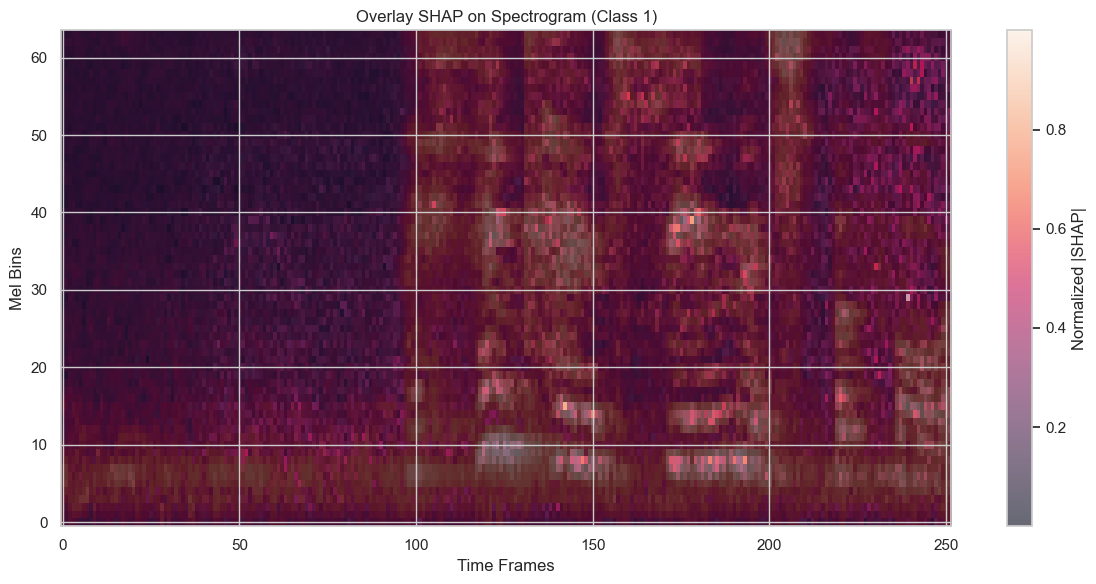

In [27]:
# Ensure model is in eval mode
model.eval()

# Get the first test example
x0 = X_test[0].unsqueeze(0)  # shape (1,1,64,252)

# Compute prediction
with torch.no_grad():
    logits = model(x0)
pred_class = int(torch.argmax(logits, dim=1).item())

print("Predicted class:", pred_class)

# Original spectrogram
orig_spec = X_test[0].detach().cpu().numpy()[0]   # (64,252)

# Corresponding SHAP map
shap_map = processed_shap[pred_class]

# Normalize SHAP for visualization
shap_norm = np.abs(shap_map) / (np.max(np.abs(shap_map)) + 1e-6)

plt.figure(figsize=(12, 6))
plt.title(f"Overlay SHAP on Spectrogram (Class {pred_class})")

# Spectrogram
plt.imshow(orig_spec, aspect='auto', origin='lower')

# SHAP overlay
plt.imshow(shap_norm, aspect='auto', origin='lower', alpha=0.6)

plt.colorbar(label="Normalized |SHAP|")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bins")
plt.tight_layout()
plt.show()


In [28]:
# Optional: expand SHAP to more samples
num_to_explain = min(10, X_test.shape[0])  # choose up to 10 samples
X_explain = X_test[:num_to_explain]

explainer_input = X_explain.to(device)

print("Explaining", explainer_input.shape[0], "samples...")

shap_values_batch = []
for i in range(explainer_input.shape[0]):
    sv_i = explainer.shap_values(explainer_input[i:i+1])  # list of arrays per class
    shap_values_batch.append(sv_i)

print("SHAP batch done:")
print("len:", len(shap_values_batch))


Explaining 10 samples...
SHAP batch done:
len: 10


#### Aggregate SHAP magnitudes per sample

In [29]:
def pool_shap_over_classes(sv):
    """
    sv: numpy array (64,252,6)
    returns: pooled SHAP (64,252)
    """
    return np.mean(np.abs(sv), axis=-1)

pooled_shap_batch = []
for sample in shap_values_batch:
    # sample is a list of length num_classes; each element is (1,64,252,6)
    sv = sample[0][0]           # get actual array (64,252,6)
    pooled = pool_shap_over_classes(sv)
    pooled_shap_batch.append(pooled)

print("Computed pooled SHAP for", len(pooled_shap_batch), "samples.")


Computed pooled SHAP for 10 samples.


#### Plot pooled SHAP summary for one sample

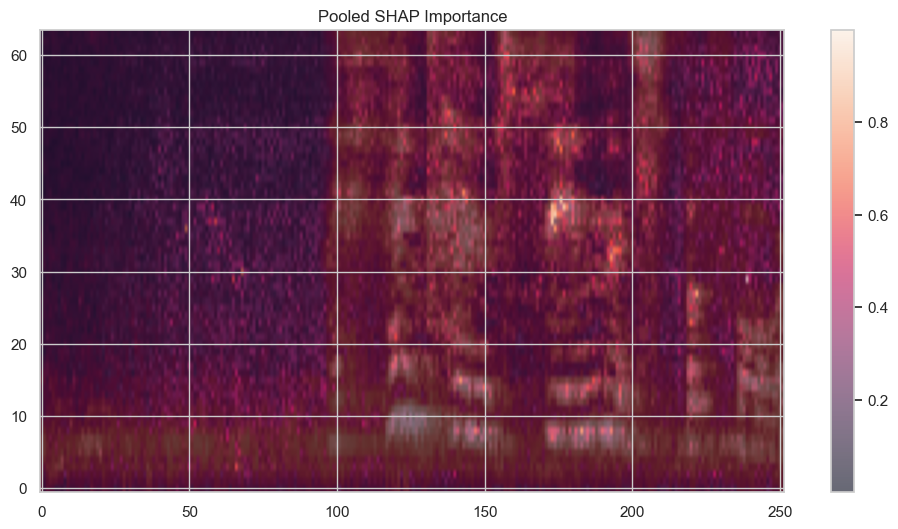

In [30]:
idx = 0  # first sample
spec = X_explain[idx].cpu().numpy()[0]
shap_map = pooled_shap_batch[idx]

plt.figure(figsize=(12,6))
plt.title("Pooled SHAP Importance")
plt.imshow(spec, aspect='auto', origin='lower')
plt.imshow(shap_map / (shap_map.max()+1e-6),
           aspect='auto', origin='lower', alpha=0.6)
plt.colorbar()
plt.show()


#### Plot pooled SHAP summary for one sample

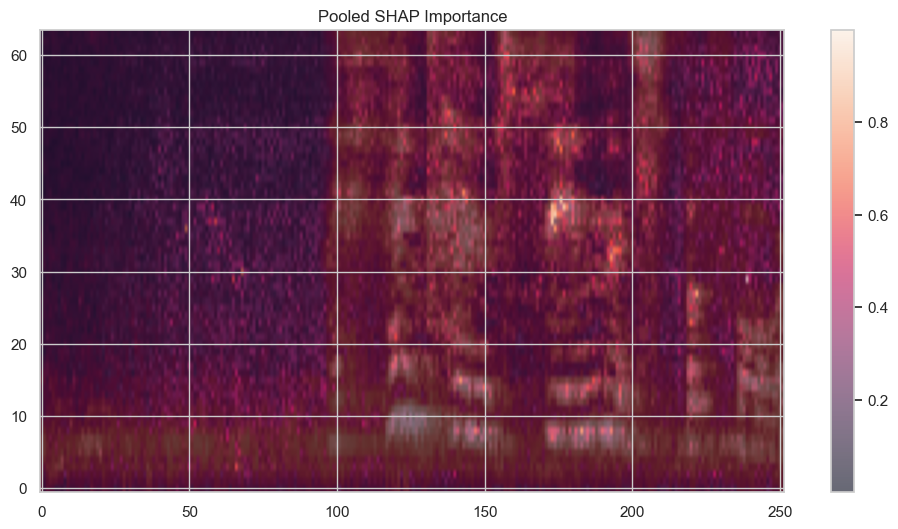

In [31]:
idx = 0  # first sample
spec = X_explain[idx].cpu().numpy()[0]
shap_map = pooled_shap_batch[idx]

plt.figure(figsize=(12,6))
plt.title("Pooled SHAP Importance")
plt.imshow(spec, aspect='auto', origin='lower')
plt.imshow(shap_map / (shap_map.max()+1e-6),
           aspect='auto', origin='lower', alpha=0.6)
plt.colorbar()
plt.show()


#### Compute demographic SHAP scores (per-group explainability)

In [34]:
# --------------------------
# Load full metadata
# --------------------------
import pandas as pd
import os

meta_df = pd.read_csv("../../data/processed/metadata.csv")

print("Metadata loaded:", meta_df.shape)

# Ensure filename column exists (adjust if your column name differs)
if "file" in meta_df.columns:
    meta_df["basename"] = meta_df["file"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
elif "filename" in meta_df.columns:
    meta_df["basename"] = meta_df["filename"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
else:
    raise ValueError("No filename column found in metadata. Columns: " + str(meta_df.columns))


# --------------------------
# Match SHAP test files to metadata
# --------------------------
test_files = [os.path.splitext(os.path.basename(p))[0] for p in test_paths]
print("Test files:", test_files)

test_meta = meta_df[meta_df["basename"].isin(test_files)].reset_index(drop=True)

print("Matched metadata rows:", test_meta.shape)
display(test_meta.head())

# Attach pooled shap values
test_meta["pooled_shap"] = pooled_shap_batch

print("Final test_meta with SHAP added:")
display(test_meta.head())


Metadata loaded: (7442, 9)
Test files: ['1003_ITS_HAP_XX', '1003_ITS_NEU_XX', '1003_ITS_SAD_XX', '1003_IWL_ANG_XX', '1003_IWL_DIS_XX', '1003_IWL_FEA_XX', '1003_IWL_HAP_XX', '1003_IWL_NEU_XX', '1003_IWL_SAD_XX', '1003_IWW_ANG_XX']
Matched metadata rows: (10, 10)


Stimulus_Number             file  ActorID  Age     Sex       Race  \
0              195  1003_IWW_ANG_XX     1003   21  Female  Caucasian   
1              210  1003_IWL_NEU_XX     1003   21  Female  Caucasian   
2              211  1003_IWL_HAP_XX     1003   21  Female  Caucasian   
3              212  1003_IWL_SAD_XX     1003   21  Female  Caucasian   
4              213  1003_IWL_ANG_XX     1003   21  Female  Caucasian   

      Ethnicity                                         audio_path  \
0  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
1  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
2  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
3  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
4  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   

                                          clean_path         basename  
0  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWW_ANG_XX  
1  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_NEU_XX  
2  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_HAP_XX  
3  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_SAD_XX  
4  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_ANG_XX

Final test_meta with SHAP added:


Stimulus_Number             file  ActorID  Age     Sex       Race  \
0              195  1003_IWW_ANG_XX     1003   21  Female  Caucasian   
1              210  1003_IWL_NEU_XX     1003   21  Female  Caucasian   
2              211  1003_IWL_HAP_XX     1003   21  Female  Caucasian   
3              212  1003_IWL_SAD_XX     1003   21  Female  Caucasian   
4              213  1003_IWL_ANG_XX     1003   21  Female  Caucasian   

      Ethnicity                                         audio_path  \
0  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
1  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
2  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
3  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
4  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   

                                          clean_path         basename  \
0  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWW_ANG_XX   
1  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_NEU_XX   
2  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_HAP_XX   
3  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_SAD_XX   
4  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_IWL_ANG_XX   

                                         pooled_shap  
0  [[5.4207799272000274e-05, 8.819193291730364e-0...  
1  [[0.0002926870974561281, 0.0001554795523370570...  
2  [[8.760057614814017e-05, 0.0002782428362609323...  
3  [[0.00018844743302425142, 0.000259476461671021...  
4  [[0.00011768216562244233, 0.000175785787000164...

#### Average SHAP Maps Per Demographic Group

In [36]:
import numpy as np
import pandas as pd
from collections import defaultdict

# Ensure SHAP values are numpy
assert isinstance(test_meta["pooled_shap"].iloc[0], np.ndarray)

# Groups we will analyze
GROUP_COLUMNS = ["Age", "Sex", "Race", "Ethnicity"]

group_shap_maps = {g: defaultdict(list) for g in GROUP_COLUMNS}

for _, row in test_meta.iterrows():
    shap_map = row["pooled_shap"]   # (64, 252)
    for g in GROUP_COLUMNS:
        group_value = row[g]
        group_shap_maps[g][group_value].append(shap_map)

# Compute the average SHAP map for each group
group_shap_avg = {g: {} for g in GROUP_COLUMNS}

for g in GROUP_COLUMNS:
    for value, maps in group_shap_maps[g].items():
        maps = np.stack(maps)                    # (N, 64, 252)
        avg_map = maps.mean(axis=0)              # (64, 252)
        group_shap_avg[g][value] = avg_map

print("Computed group-level SHAP averages.")


Computed group-level SHAP averages.


#### Plot Group-Level SHAP Heatmaps


=== SHAP for Age Groups ===


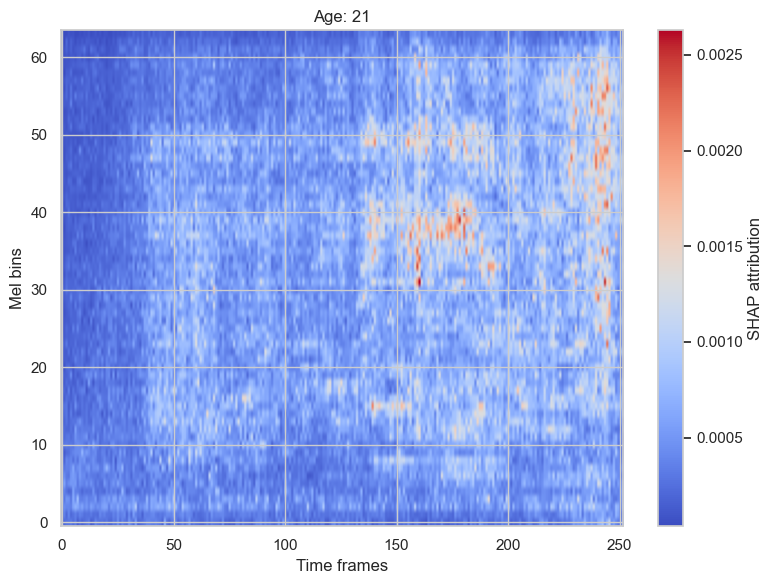


=== SHAP for Sex Groups ===


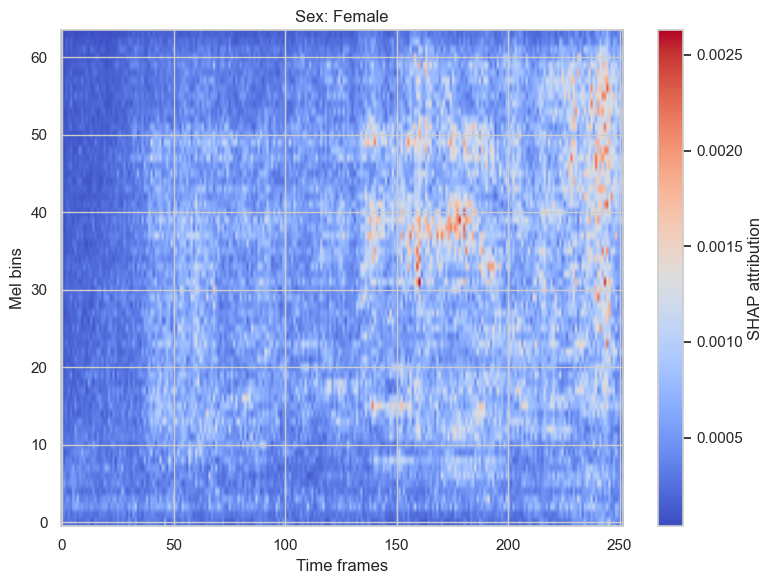


=== SHAP for Race Groups ===


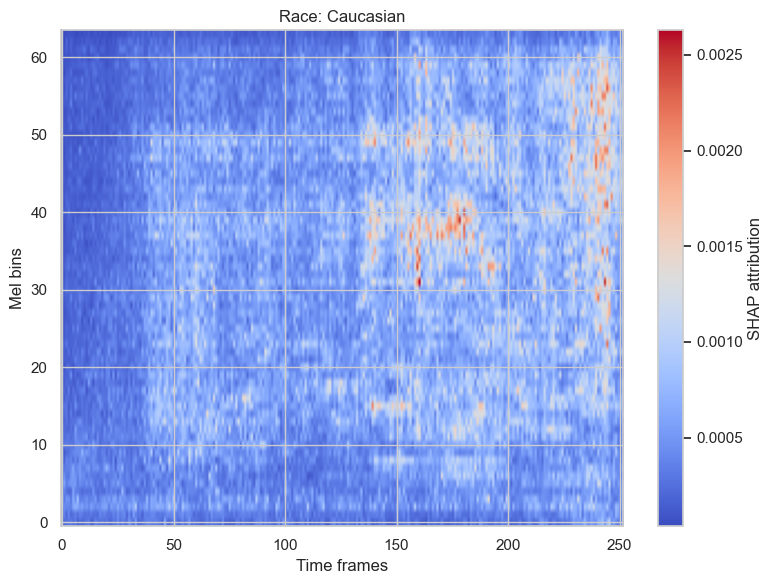


=== SHAP for Ethnicity Groups ===


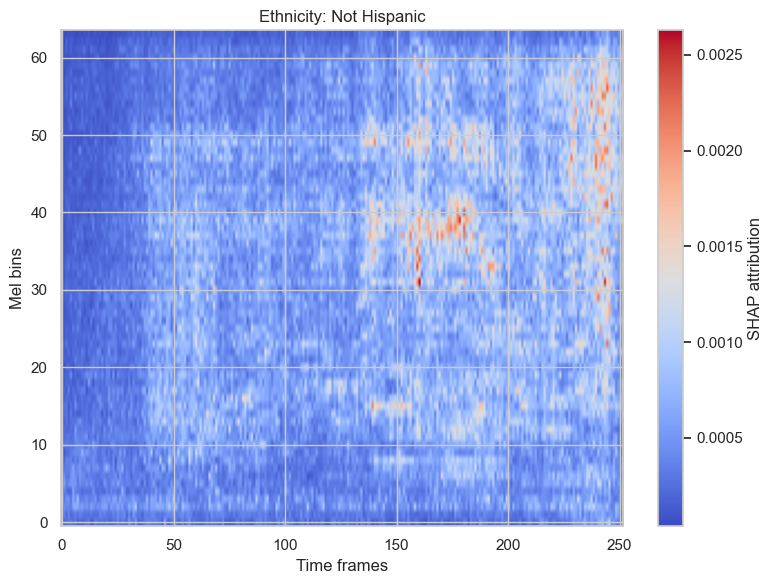

In [37]:
import matplotlib.pyplot as plt

def plot_group_shap(shap_map, title):
    plt.figure(figsize=(8,6))
    plt.imshow(shap_map, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label="SHAP attribution")
    plt.title(title)
    plt.xlabel("Time frames")
    plt.ylabel("Mel bins")
    plt.tight_layout()
    plt.show()

# Plot for each demographic group
for col in GROUP_COLUMNS:
    print(f"\n=== SHAP for {col} Groups ===")
    for val, m in group_shap_avg[col].items():
        plot_group_shap(m, f"{col}: {val}")


#### Compute SHAP Intensity per Group

In [38]:
group_intensity = {g:{} for g in GROUP_COLUMNS}

for g in GROUP_COLUMNS:
    for val, m in group_shap_avg[g].items():
        intensity = np.abs(m).mean()
        group_intensity[g][val] = intensity

pd.DataFrame(group_intensity)


Age       Sex      Race  Ethnicity
21            0.000606       NaN       NaN        NaN
Female             NaN  0.000606       NaN        NaN
Caucasian          NaN       NaN  0.000606        NaN
Not Hispanic       NaN       NaN       NaN   0.000606

#### Bar Charts of SHAP Intensity per Group

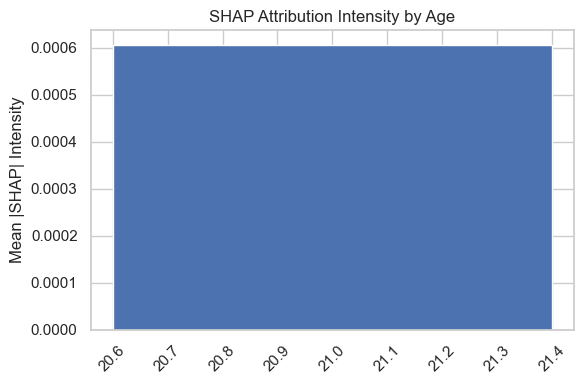

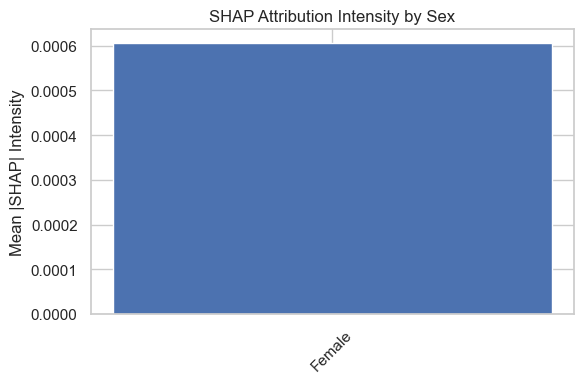

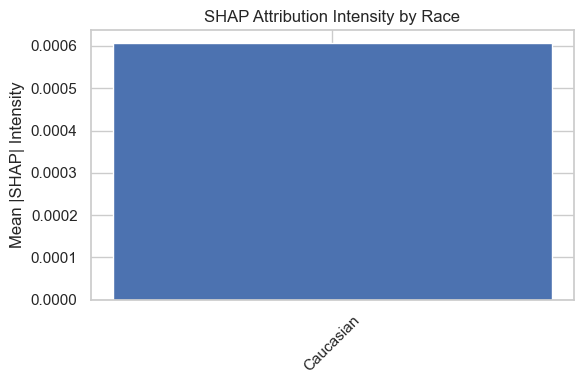

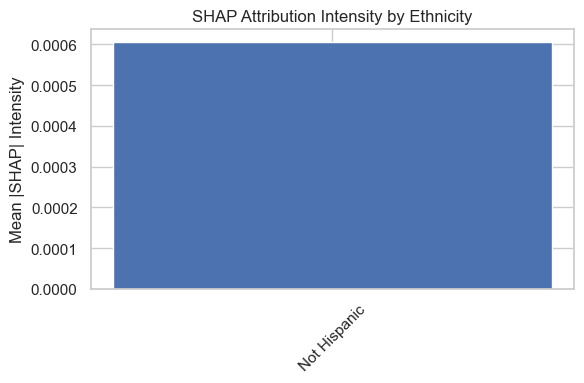

In [39]:
import matplotlib.pyplot as plt

def plot_intensity_bars(group_dict, title):
    labels = list(group_dict.keys())
    values = list(group_dict.values())

    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Mean |SHAP| Intensity")
    plt.tight_layout()
    plt.show()

for g in GROUP_COLUMNS:
    plot_intensity_bars(group_intensity[g], f"SHAP Attribution Intensity by {g}")


#### Compute Disparity Scores (Bias Explainability Metric)

In [42]:
# Global average SHAP over all test samples
global_shap = np.mean(np.stack(test_meta["pooled_shap"].tolist()), axis=0)

disparity_scores = {g:{} for g in GROUP_COLUMNS}

for g in GROUP_COLUMNS:
    for val, m in group_shap_avg[g].items():
        disparity = np.abs(m - global_shap).mean()  # L1 distance
        disparity_scores[g][val] = disparity

pd.DataFrame(disparity_scores)


Age  Sex  Race  Ethnicity
21            0.0  NaN   NaN        NaN
Female        NaN  0.0   NaN        NaN
Caucasian     NaN  NaN   0.0        NaN
Not Hispanic  NaN  NaN   NaN        0.0

#### Plot Disparity (Bias Heatmaps)


=== SHAP Disparity Heatmaps for Age ===


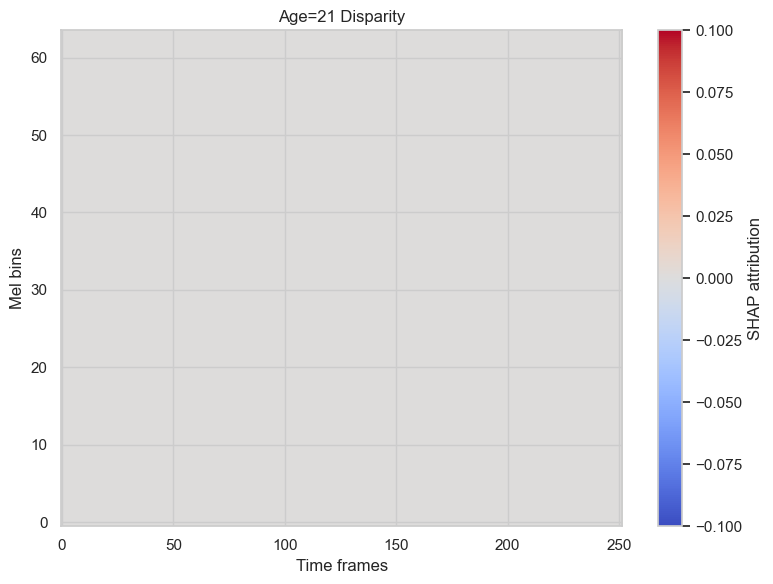


=== SHAP Disparity Heatmaps for Sex ===


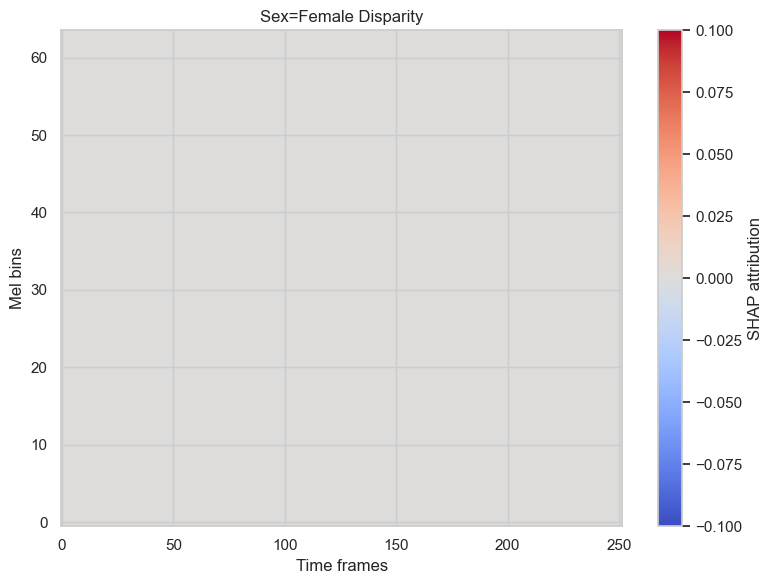


=== SHAP Disparity Heatmaps for Race ===


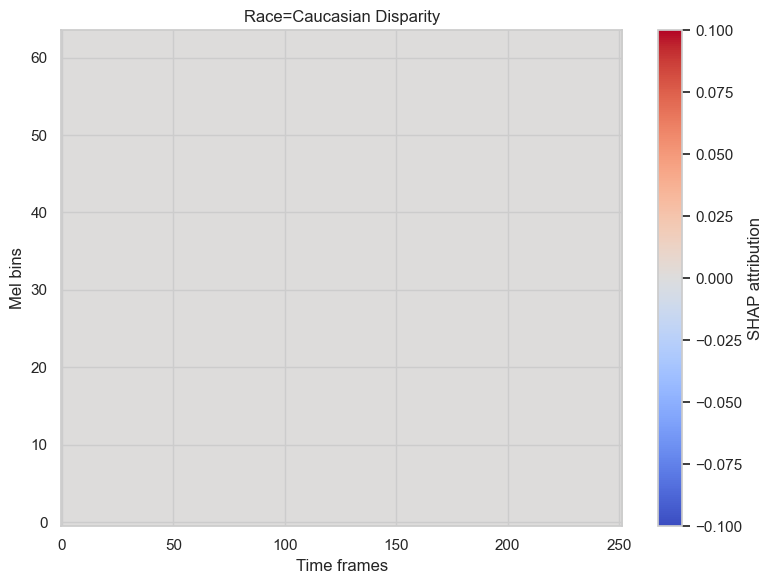


=== SHAP Disparity Heatmaps for Ethnicity ===


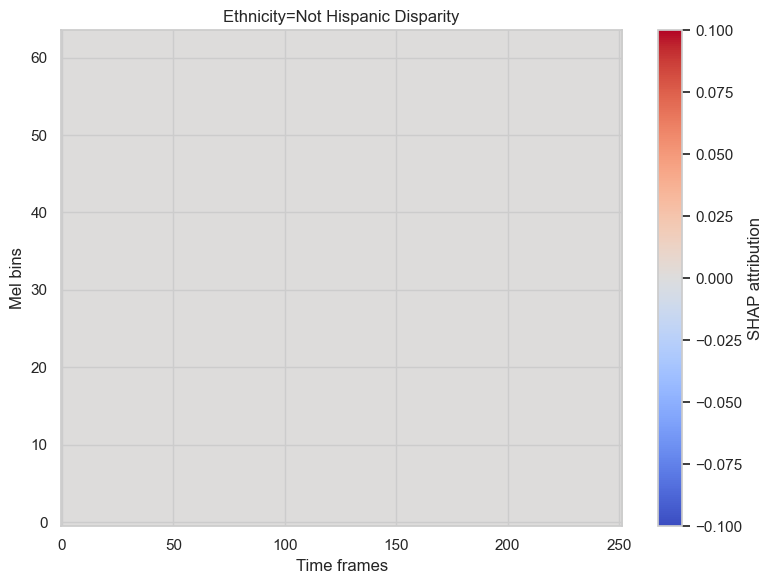

In [43]:
for g in GROUP_COLUMNS:
    print(f"\n=== SHAP Disparity Heatmaps for {g} ===")
    for val, m in group_shap_avg[g].items():
        diff_map = np.abs(m - global_shap)
        plot_group_shap(diff_map, f"{g}={val} Disparity")


#### Summary Explainability Report (Table)

In [44]:
report_rows = []

for g in GROUP_COLUMNS:
    for val in group_intensity[g].keys():
        report_rows.append({
            "Group": g,
            "Value": val,
            "SHAP_Intensity": group_intensity[g][val],
            "SHAP_Disparity": disparity_scores[g][val],
            "Count": len(group_shap_maps[g][val])
        })

explainability_report = pd.DataFrame(report_rows)
explainability_report


Group         Value  SHAP_Intensity  SHAP_Disparity  Count
0        Age            21        0.000606             0.0     10
1        Sex        Female        0.000606             0.0     10
2       Race     Caucasian        0.000606             0.0     10
3  Ethnicity  Not Hispanic        0.000606             0.0     10

#### Attach Metadata to SHAP samples

In [47]:
# --------------------------------------------
# Attach matching metadata rows for the X_test items
# --------------------------------------------

# We used indices 200:210 in X_test. Let's extract matching rows:
meta_subset = meta_df.iloc[200:200+len(X_test)].reset_index(drop=True)

print("Metadata subset:")
display(meta_subset.head())

print("Demographic counts in this sample:")
print(meta_subset[['Race','Sex','Age']].value_counts())


Metadata subset:


Stimulus_Number             file  ActorID  Age     Sex       Race  \
0              201  1003_TAI_ANG_XX     1003   21  Female  Caucasian   
1              202  1003_TAI_FEA_XX     1003   21  Female  Caucasian   
2              203  1003_TAI_DIS_XX     1003   21  Female  Caucasian   
3              204  1003_MTI_NEU_XX     1003   21  Female  Caucasian   
4              205  1003_MTI_HAP_XX     1003   21  Female  Caucasian   

      Ethnicity                                         audio_path  \
0  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
1  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
2  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
3  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
4  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   

                                          clean_path         basename  
0  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_TAI_ANG_XX  
1  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_TAI_FEA_XX  
2  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_TAI_DIS_XX  
3  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_MTI_NEU_XX  
4  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1003_MTI_HAP_XX

Demographic counts in this sample:
Race       Sex     Age
Caucasian  Female  21     10
Name: count, dtype: int64


#### Compute Group Level SHAP aggregations

In [48]:
import numpy as np
import pandas as pd
from collections import defaultdict

# pooled_shap_batch = list of shape (64,252)
# meta_subset = corresponding demographic labels

group_shap = defaultdict(list)

for sv, (_, row) in zip(pooled_shap_batch, meta_subset.iterrows()):
    # Choose which demographic to inspect
    key = row['Race']   # change to Sex or Age as needed
    group_shap[key].append(sv)

# Compute mean SHAP per group
group_mean_shap = {g: np.mean(np.stack(vals), axis=0) for g, vals in group_shap.items()}

print("Computed mean SHAP for groups:", list(group_mean_shap.keys()))


Computed mean SHAP for groups: ['Caucasian']


#### Plot Group Level SHAP heatmaps

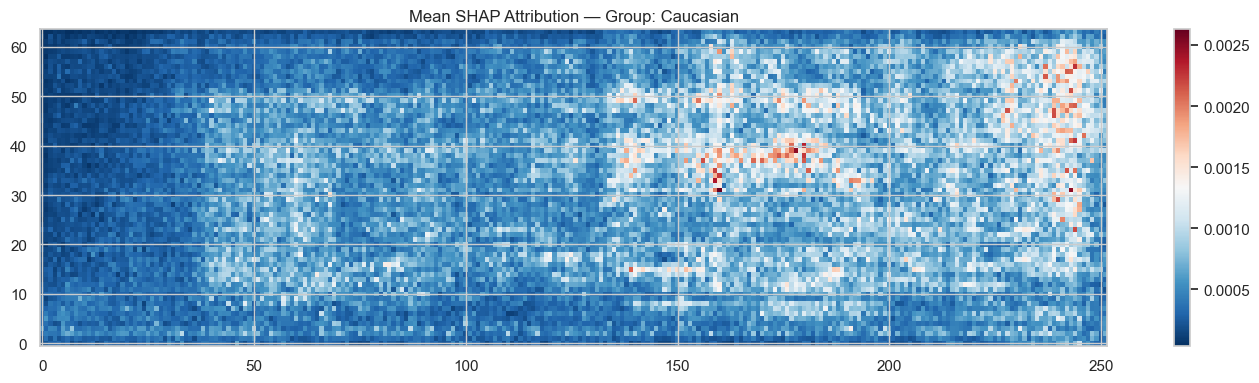

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4*len(group_mean_shap)))

i=1
for group, sv in group_mean_shap.items():
    plt.subplot(len(group_mean_shap), 1, i)
    plt.imshow(sv, aspect='auto', origin='lower', cmap='RdBu_r')
    plt.colorbar()
    plt.title(f"Mean SHAP Attribution — Group: {group}")
    i += 1

plt.tight_layout()
plt.show()


#### Find Region with multiple groups

In [52]:
# Check demographic diversity across the entire test metadata
print("Available Race groups in metadata_test:")
print(meta_df["Race"].value_counts())

print("\nAvailable Sex groups:")
print(meta_df["Sex"].value_counts())

print("\nAvailable Age groups:")
print(meta_df["Age"].value_counts())


Available Race groups in metadata_test:
Race
Caucasian           4988
African American    1804
Asian                568
Unknown               82
Name: count, dtype: int64

Available Sex groups:
Sex
Male      3930
Female    3512
Name: count, dtype: int64

Available Age groups:
Age
21    573
25    573
33    492
22    492
42    410
24    322
31    246
30    246
51    246
38    246
29    240
36    164
62    164
34    164
40    164
20    164
45    164
56    164
57    164
61    164
23    164
32    164
48    164
27    164
46    158
44     82
28     82
58     82
41     82
66     82
53     82
35     82
52     82
37     82
59     82
49     82
74     82
50     82
Name: count, dtype: int64


In [60]:
# Load your already-saved split CSVs
meta_train = pd.read_csv("../../data/processed/metadata_train.csv")
meta_val = pd.read_csv("../../data/processed/metadata_val.csv")
meta_test = pd.read_csv("../../data/processed/metadata_test.csv")

# Start fresh: create a mapping from filename → split label
split_map = {}

for f in meta_train["file"]:
    split_map[f] = "train"

for f in meta_val["file"]:
    split_map[f] = "val"

for f in meta_test["file"]:
    split_map[f] = "test"

# Now add split column to your full metadata dataframe
meta_df["split"] = meta_df["file"].map(split_map)

# Check if any rows failed to map
print("Rows without split label:", meta_df["split"].isna().sum())

meta_df.head()


Rows without split label: 0


Stimulus_Number             file  ActorID  Age   Sex       Race  \
0                1  1001_IEO_NEU_XX     1001   51  Male  Caucasian   
1                2  1001_IEO_HAP_LO     1001   51  Male  Caucasian   
2                3  1001_IEO_HAP_MD     1001   51  Male  Caucasian   
3                4  1001_IEO_HAP_HI     1001   51  Male  Caucasian   
4                5  1001_IEO_SAD_LO     1001   51  Male  Caucasian   

      Ethnicity                                         audio_path  \
0  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
1  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
2  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
3  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
4  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   

                                          clean_path         basename  split  
0  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1001_IEO_NEU_XX  train  
1  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1001_IEO_HAP_LO  train  
2  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1001_IEO_HAP_MD  train  
3  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1001_IEO_HAP_HI  train  
4  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1001_IEO_SAD_LO  train

In [61]:
meta_test_full = meta_df[meta_df["split"] == "test"].reset_index(drop=True)
print(len(meta_test_full), len(X_test))


1060 10


In [66]:
# Count group sizes for test set
ethnicity_counts = meta_test_full["Ethnicity"].value_counts()
race_counts = meta_test_full["Race"].value_counts()
sex_counts  = meta_test_full["Sex"].value_counts()

print("Ethnicity with >=2 samples:")
print(ethnicity_counts[ethnicity_counts >= 2])

print("\nRaces with >=2 samples:")
print(race_counts[race_counts >= 2])

print("\nSex groups with >=2 samples:")
print(sex_counts[sex_counts >= 2])


Ethnicity with >=2 samples:
Ethnicity
Not Hispanic    896
Hispanic        164
Name: count, dtype: int64

Races with >=2 samples:
Race
Caucasian           732
African American    246
Asian                82
Name: count, dtype: int64

Sex groups with >=2 samples:
Sex
Male      574
Female    486
Name: count, dtype: int64


In [68]:
# Rebuild processed_shap_batch safely

import numpy as np

# processed_shap should exist from previous SHAP extraction
try:
    print("processed_shap length:", len(processed_shap))
    print("processed_shap[0] shape:", processed_shap[0].shape)
except NameError:
    raise ValueError("processed_shap is not defined. Go back to the cell where SHAP was processed.")

# Stack into array: (N, 64, 252)
processed_shap_batch = np.stack(processed_shap)
print("processed_shap_batch shape:", processed_shap_batch.shape)


processed_shap length: 6
processed_shap[0] shape: (64, 252)
processed_shap_batch shape: (6, 64, 252)


In [70]:
# Ensure SHAP and metadata align
N_SHAP = len(processed_shap)    # Should be 6
N_META = len(meta_test)

print("SHAP samples:", N_SHAP)
print("Metadata rows:", N_META)

# Subset metadata to match SHAP length
meta_test_subset = meta_test.iloc[:N_SHAP].copy()
meta_test_subset['shap_index'] = np.arange(N_SHAP)

print("Subset shape:", meta_test_subset.shape)
meta_test_subset.head()


SHAP samples: 6
Metadata rows: 1060
Subset shape: (6, 12)


Stimulus_Number             file  ActorID  Age     Sex       Race  \
0              410  1006_IEO_NEU_XX     1006   58  Female  Caucasian   
1              411  1006_IEO_HAP_LO     1006   58  Female  Caucasian   
2              412  1006_IEO_HAP_MD     1006   58  Female  Caucasian   
3              413  1006_IEO_HAP_HI     1006   58  Female  Caucasian   
4              414  1006_IEO_SAD_LO     1006   58  Female  Caucasian   

      Ethnicity                                         audio_path  \
0  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
1  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
2  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
3  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   
4  Not Hispanic  /Users/pc/Desktop/CODING/Others/fairvoice/data...   

                                          clean_path         basename split  \
0  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1006_IEO_NEU_XX  test   
1  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1006_IEO_HAP_LO  test   
2  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1006_IEO_HAP_MD  test   
3  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1006_IEO_HAP_HI  test   
4  /Users/pc/Desktop/CODING/Others/fairvoice/data...  1006_IEO_SAD_LO  test   

   shap_index  
0           0  
1           1  
2           2  
3           3  
4           4

✓ SHAP array: (6, 64, 252)
✓ Metadata subset: (6, 13)
Using demographic columns: ['Sex', 'Race', 'Ethnicity']

=== Sex groups: ['Female']


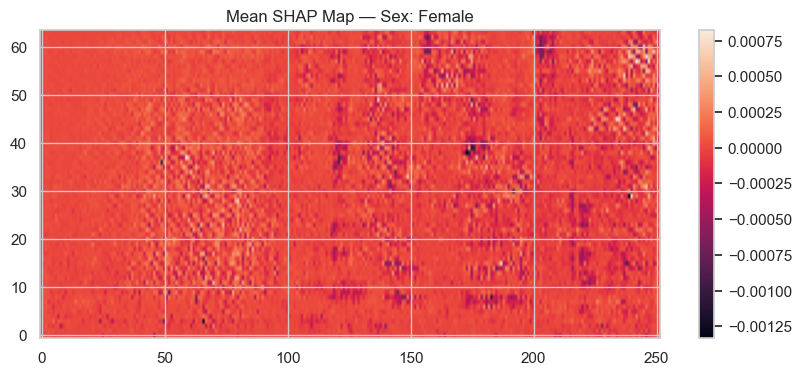


=== Race groups: ['Caucasian']


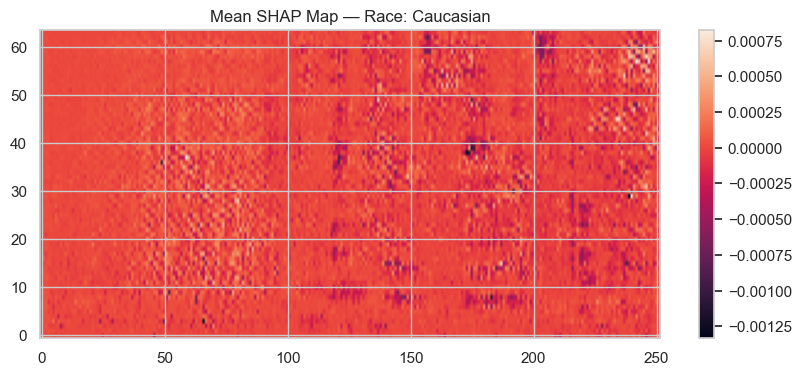


=== Ethnicity groups: ['Not Hispanic']


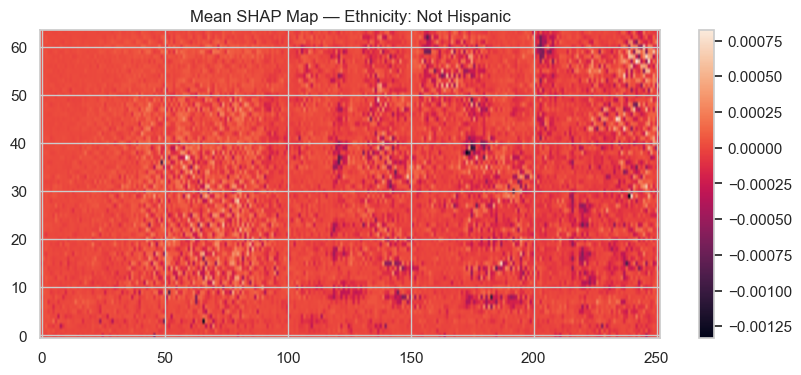


✓ Explainability complete (SHAP group maps + differences).


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. SHAP array + merge
# -----------------------------
shap_values = np.stack(processed_shap)   # (6, 64, 252)
meta_test_subset['shap_values'] = list(shap_values)

print("✓ SHAP array:", shap_values.shape)
print("✓ Metadata subset:", meta_test_subset.shape)


# -----------------------------
# 2. Demographic columns
# -----------------------------
valid_demographics = [c for c in meta_test_subset.columns
                      if c.lower() in ["race", "sex", "ethnicity"]]

print("Using demographic columns:", valid_demographics)


# -----------------------------
# 3. For each demographic → compute mean SHAP per group
# -----------------------------
all_mean_maps = {}  # demo → group → map

for demo in valid_demographics:
    groups = meta_test_subset[demo].unique()
    print(f"\n=== {demo} groups:", groups)

    mean_maps = {}
    for g in groups:
        idx = meta_test_subset[meta_test_subset[demo] == g].index
        maps = np.stack(meta_test_subset.loc[idx, "shap_values"].values)
        mean_maps[g] = maps.mean(axis=0)

        # Plot group SHAP
        plt.figure(figsize=(10,4))
        plt.imshow(mean_maps[g], aspect='auto', origin='lower')
        plt.title(f"Mean SHAP Map — {demo}: {g}")
        plt.colorbar()
        plt.show()

    all_mean_maps[demo] = mean_maps

    # -----------------------------
    # 4. Difference map (only if 2+ groups)
    # -----------------------------
    if len(groups) >= 2:
        g1, g2 = groups[:2]
        diff_map = mean_maps[g1] - mean_maps[g2]

        plt.figure(figsize=(10,4))
        plt.imshow(diff_map, aspect='auto', origin='lower')
        plt.title(f"Difference Map — {demo}: {g1} - {g2}")
        plt.colorbar()
        plt.show()

print("\n✓ Explainability complete (SHAP group maps + differences).")
